## Neural Network

In [1]:
import torch
import torch.nn as nn #neural net
import torch.nn.functional as F #Functions such as relu
import torch.optim as optim #Parameter optimization functions
import numpy as np
import random #Random shuffling
import matplotlib.pyplot as plt
from scipy.io import loadmat #Loading data

Define the network

In [2]:
class ANN(nn.Module):
    
    def __init__(self):
        #Define the network
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(400, 25)
        self.fc2 = nn.Linear(25,10)
        self.Sigmoid = nn.Sigmoid()
        self.Softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.Sigmoid(self.fc1(x))
        x = self.Softmax(self.fc2(x))
        return(x)
    
    def loadWeight(self, weights):
        
        fc1 = torch.from_numpy(weights["Theta1"][:,:-1]).float()
        fc1Bias = torch.from_numpy(weights["Theta1"][:,0]).float()
        fc2 = torch.from_numpy(weights["Theta2"][:,:-1]).float()
        fc2Bias = torch.from_numpy(weights["Theta2"][:,0]).float()
        
        print(fc1.shape)
        print(fc1Bias)
        print(fc2Bias)
        
        param = list(self.parameters())
        param[0].data.sub_(fc1)
        param[1].data.sub_(fc1Bias)
        param[2].data.sub_(fc2)
        param[3].data.sub_(fc2Bias)

In [3]:
def loadData(name):
    return(loadmat(name))

In [4]:
#Evaluate the network
def evaluate(model, data):
    dataSize = len(data["X"][:,1]) #Total number of samples.
    #Test on the dataset
    #For each of the featureset.
    samples = list(range(dataSize))
    random.shuffle(samples)
    correct = 0

    with torch.no_grad():
        for i in samples:
            features = torch.from_numpy(data["X"][i]).float()
            #Extract the correct value
            target = torch.zeros((10))
            target[data["y"][i]-1] = 1.0
            #Predict
            outputs = model(features)
            _, predicted = torch.max(outputs, 0)
            correct += (int(predicted) == data["y"][i]-1)
    return(100*correct/dataSize)

In [5]:
#Load the data. 
data = loadData("ex3data1.mat")
print("Input shape: ", data["X"].shape)
print("Output shape: ", data["y"].shape)

Input shape:  (5000, 400)
Output shape:  (5000, 1)


### Train the Network

In [12]:
#Initialize the neural net
classifier = ANN()
print(classifier)
#Create the optim
optimizer = optim.SGD(classifier.parameters(), lr=0.2)

ANN(
  (fc1): Linear(in_features=400, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=10, bias=True)
  (Sigmoid): Sigmoid()
  (Softmax): Softmax()
)


In [13]:
print("Accuracy%: ", evaluate(classifier, data))

Accuracy%:  [7.76]


In [14]:
#Training.
dataSize = len(data["X"][:,1]) #Total number of samples.
#Store the result here to plot graph.
AccuracyCount = []
LossCount = []
for epoch in range(20):
    
    losses = []
    accuracyCount = []
    correctCount = 0
    #For each of the featureset.
    samples = list(range(dataSize))
    random.shuffle(samples)
    for i in samples:
        #Train with SGD for each set. |
        optimizer.zero_grad()   # zero the gradient
        #Extract a feature i
        features = torch.from_numpy(data["X"][i]).float()
        #Extract the correct value
        target = torch.zeros((10))
        target[data["y"][i]-1] = 1.0
        #Define the MSE loss.
        output = classifier(features)
        loss = nn.MSELoss()(output, target)
        #Backprop the loss to each node.
        loss.backward()
        #Updates our weights using optim SGD.
        optimizer.step()
        #Keep track of loss and accuracy.
        losses.append(loss)
    losses = np.array(losses, dtype=float)
    accuracy = evaluate(classifier, data)[0]
    AccuracyCount.append(accuracy)
    mean = np.mean(losses)
    LossCount.append(mean)
    print("Epoch:"+ str(epoch) + " Avg MSE Loss:", mean, "Ave Accuracy%: ", accuracy)


Epoch:0 Avg MSE Loss: 0.08385751541191712 Ave Accuracy%:  47.9
Epoch:1 Avg MSE Loss: 0.05130366503710975 Ave Accuracy%:  79.8
Epoch:2 Avg MSE Loss: 0.028834163938362325 Ave Accuracy%:  88.4
Epoch:3 Avg MSE Loss: 0.020284129008754644 Ave Accuracy%:  90.32
Epoch:4 Avg MSE Loss: 0.01676851083908896 Ave Accuracy%:  91.76
Epoch:5 Avg MSE Loss: 0.01474527826936337 Ave Accuracy%:  92.32
Epoch:6 Avg MSE Loss: 0.013458292766061437 Ave Accuracy%:  92.44
Epoch:7 Avg MSE Loss: 0.012575043936965858 Ave Accuracy%:  93.4
Epoch:8 Avg MSE Loss: 0.01169310092183988 Ave Accuracy%:  93.4
Epoch:9 Avg MSE Loss: 0.011016431857423117 Ave Accuracy%:  94.04
Epoch:10 Avg MSE Loss: 0.01050728493655987 Ave Accuracy%:  94.46
Epoch:11 Avg MSE Loss: 0.009947866601639288 Ave Accuracy%:  94.56
Epoch:12 Avg MSE Loss: 0.009485902575908525 Ave Accuracy%:  95.04
Epoch:13 Avg MSE Loss: 0.009038461577512383 Ave Accuracy%:  95.22
Epoch:14 Avg MSE Loss: 0.008603023004042948 Ave Accuracy%:  95.34
Epoch:15 Avg MSE Loss: 0.008211

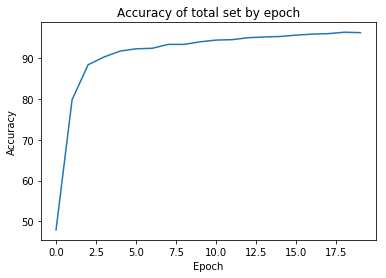

In [15]:
#Plot the accuracy gain
plt.plot(AccuracyCount)
plt.title('Accuracy of total set by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

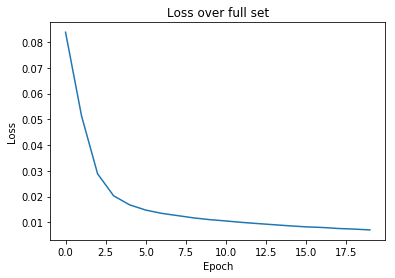

In [16]:
#Plot the loss rate
#Plot the accuracy gain
plt.plot(LossCount)
plt.title('Loss over full set')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Comparison with Logistic linear regression strategy (One vs Many)

In [17]:
from sklearn.preprocessing import scale

ModuleNotFoundError: No module named 'sklearn'

### Accuracy of loaded weights

In [ ]:
#Load some weights
weights = loadData("ex3weights.mat")
classifier.loadWeight(weights)

In [ ]:
print("Accuracy%: ", evaluate(classifier, data))